# Scraping Tripadvisor: Analysis of all reviews given to the Best Rated Local Cusine Restaurant in Barcelona - Bodega Biarritz 1881

__________________________________________________________________________________________________________________

### Objective

What are clients saying about the best rated local curinse restaurant in Barcelona? 

### Web Scraping Steps
0. Imports
1. Get main information about top1 local cusine restaurant (including: name, rating, reviews, dates of reviews...)
2. Analyse all reviews
    - Main mention words
    - Sentiment Analysis
    - Evolution during Last 5 years (2015-2020)
       
3. Get Conclusions
__________________________________________________________________________________________________________________

#### 0. Imports

In [47]:
import random
import time
from selenium import webdriver
import csv
import pandas as pd
import requests
from bs4 import BeautifulSoup
from wordcloud import WordCloud, ImageColorGenerator
import matplotlib.pyplot as plt
from datetime import datetime, date, time

#### 1. Get main information about top1 and worst local cusine restaurant (including: name, rating, reviews, dates...) -  using Selenium

#### Opening url

In [52]:
#abrimos url en incognito y sin que se abra cada vez
options = webdriver.ChromeOptions()
options.add_argument('--ignore-certificate-errors')
options.add_argument('--incognito')
options.add_argument('--headless')

#importamos webdriver
driver=webdriver.Chrome("/Applications/chromedriver",chrome_options=options)


#abrimos url info
driver.get("https://www.tripadvisor.com/Restaurant_Review-g187497-d3832462-Reviews-Bodega_Biarritz_1881-Barcelona_Catalonia.html")

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: use options instead of chrome_options
  


In [53]:
# function to check if the button is on the page, to avoid miss-click problem
def check_exists_by_xpath(xpath):
    try:
        driver.find_element_by_xpath(xpath)
    except NoSuchElementException:
        return False
    return True

#### Opening csv file to keep data from url

In [54]:
# open the file to save the review
csvFile = open("/Users/annavilardell/Desktop/BootcampData/PR03-project-web/PR03-project-web-Anna/Tripadvisor_Bcn_CatalanRestaurant_Top1_Reviews.csv", 'a')
csvWriter = csv.writer(csvFile)
csvWriter.writerow(["Rating","Review Quote","Full Review","Date of review","Date of visit"])

62

#### Getting specific data from url and saving it to our csv file


In [55]:
#Data we expect to get:
#1_763 reviews totales de 177 paginas totales

for i in range(0,177):
    try:
        
        if (check_exists_by_xpath("//span[@class='taLnk ulBlueLinks']")):

            # Recogemos todo el review (incl el que no se enseña porque es muy largo y lleva un botón de "more") 
            driver.find_element_by_xpath("//span[@class='taLnk ulBlueLinks']").click()
            time.sleep(5)

        container = driver.find_elements_by_xpath("//div[@class='rev_wrap ui_columns is-multiline']")
        num_page_items = len(container);

        for j in range(num_page_items):

            # Guardamos el rating
            string = container[j].find_element_by_xpath(".//span[contains(@class, 'ui_bubble_rating bubble_')]").get_attribute("class")
            data = string.split("_")

            # Guardamos la información seleccionada en el csv que creamos anteriormente
            csvWriter.writerow([data[3],
                                container[j].find_element_by_xpath(".//div[@class='quote']").text,
                                container[j].find_element_by_xpath(".//div[@class='entry']").text.replace("\n", ""),
                                container[j].find_element_by_xpath(".//span[@class='ratingDate']").text,
                                container[j].find_element_by_xpath(".//div[@class='prw_rup prw_reviews_stay_date_hsx']").text])

        # Cambiamos de pagina para tener todos los reviews de cada una de ellas
        if (check_exists_by_xpath('//a[@class="nav next ui_button primary  cx_brand_refresh_phase2"]')):
            driver.find_element_by_xpath('//a[@class="nav next ui_button primary  cx_brand_refresh_phase2"]').click()
        time.sleep(5)
    
    except Exception as Error:
        print ("Oops: An Error occurred:",Error)

driver.close()



Oops: An Error occurred: name 'NoSuchElementException' is not defined


In [56]:
#1760 review recopiladas antes del error

#### 2. Analyse all reviews

##### Putting data in a DataFrame

In [230]:
data=pd.read_csv("Tripadvisor_Bcn_CatalanRestaurant_Top1_Reviews.csv")

In [231]:
data

,Rating,Review Quote,Full Review,Date of review,Date of visit
0,40,nice tapas and wine,The place is cool and authentic decor ! Waiter...,"Reviewed June 12, 2020",Date of visit: August 2019
1,50,Best tapas in Barcelona?,"If you’re in Barcelona, you’ll want to try som...","Reviewed March 14, 2020",Date of visit: March 2020
2,50,Yummy tapas!,We were looking for a different Bodega Biarrit...,"Reviewed March 8, 2020",Date of visit: February 2020
3,50,Amazing!,"The food was awesome, the atmospher was very c...","Reviewed March 6, 2020",Date of visit: March 2020
4,50,Best Tapas in Barcelona,It was super packed when my party of 3 arrived...,"Reviewed March 2, 2020",Date of visit: March 2020
...,...,...,...,...,...
1755,50,Nipped in for a drink...... 4 hours later... f...,Passed this little tapas bar just of Placa Rei...,"Reviewed June 25, 2013",Date of visit: April 2013
1756,50,Top Tapas,This small cosy tapas bar just off the square ...,"Reviewed June 2, 2013",Date of visit: May 2013
1757,30,Not bad but not amazing,We went to this little restaurant last night. ...,"Reviewed June 1, 2013",Date of visit: May 2013
1758,50,The best tapas in town!,A gem in a little street of of the placa real ...,"Reviewed May 21, 2013",Date of visit: May 2013


In [232]:
#reviews totales
len(data)

1760

##### Adding columns with usefull data

In [233]:
#añadimos columna con el total de palabras que tiene cada review.
#hypothesis: review más largas nos dan más info
data["Total Words Review"]=data["Full Review"].apply(lambda x: len(x.split()))

In [234]:
#comprobamos
data.head(3)

,Rating,Review Quote,Full Review,Date of review,Date of visit,Total Words Review
0,40,nice tapas and wine,The place is cool and authentic decor ! Waiter...,"Reviewed June 12, 2020",Date of visit: August 2019,44
1,50,Best tapas in Barcelona?,"If you’re in Barcelona, you’ll want to try som...","Reviewed March 14, 2020",Date of visit: March 2020,141
2,50,Yummy tapas!,We were looking for a different Bodega Biarrit...,"Reviewed March 8, 2020",Date of visit: February 2020,129


In [235]:
#Encontramos las stopwords (palabra sin significado propio) de cada review
import nltk
from nltk.corpus import stopwords 
stop_words=stopwords.words("english")

In [236]:
data["Total StopWords"]=data["Full Review"].apply(lambda x: len([word for word in x.split() if word.lower() in stop_words]))



In [237]:
#comprobamos
data.head(3)

,Rating,Review Quote,Full Review,Date of review,Date of visit,Total Words Review,Total StopWords
0,40,nice tapas and wine,The place is cool and authentic decor ! Waiter...,"Reviewed June 12, 2020",Date of visit: August 2019,44,20
1,50,Best tapas in Barcelona?,"If you’re in Barcelona, you’ll want to try som...","Reviewed March 14, 2020",Date of visit: March 2020,141,59
2,50,Yummy tapas!,We were looking for a different Bodega Biarrit...,"Reviewed March 8, 2020",Date of visit: February 2020,129,66


###### Cleaning data

In [238]:
#Cleaning column Rating
#Separamos el rating del 0 para tener un rating del 1-5 
data["Rating"].head(3)

0    40
1    50
2    50
Name: Rating, dtype: int64

In [239]:
rating_clean=[]
for i in data["Rating"]:
    rating=[digit for digit in str(data["Rating"][i])]
    rating_clean.append(rating[0])

In [240]:
data["Rating"]=rating_clean

In [241]:
data["Rating"]

0       5
1       4
2       4
3       4
4       4
       ..
1755    4
1756    4
1757    5
1758    4
1759    4
Name: Rating, Length: 1760, dtype: object

In [243]:
#comprobamos
data.head(3)

,Rating,Review Quote,Full Review,Date of review,Date of visit,Total Words Review,Total StopWords
0,5,nice tapas and wine,The place is cool and authentic decor ! Waiter...,"Reviewed June 12, 2020",Date of visit: August 2019,44,20
1,4,Best tapas in Barcelona?,"If you’re in Barcelona, you’ll want to try som...","Reviewed March 14, 2020",Date of visit: March 2020,141,59
2,4,Yummy tapas!,We were looking for a different Bodega Biarrit...,"Reviewed March 8, 2020",Date of visit: February 2020,129,66


In [244]:
#Cleaning column "Date of review" 
data["Date of review"]=data["Date of review"].str.replace("Reviewed","")


In [245]:
#Cleaning column "Date of visit"
data["Date of visit"]=data["Date of visit"].str.replace("Date of visit:","")


In [246]:
#Split year,month and date of column "Date of review" 
data["Date of review"]=data["Date of review"].str.split(",")
data["Date of review"]

0        [ June 12,  2020]
1       [ March 14,  2020]
2        [ March 8,  2020]
3        [ March 6,  2020]
4        [ March 2,  2020]
               ...        
1755     [ June 25,  2013]
1756      [ June 2,  2013]
1757      [ June 1,  2013]
1758      [ May 21,  2013]
1759    [ April 28,  2013]
Name: Date of review, Length: 1760, dtype: object

In [247]:
data["Date of review"][1]

[' March 14', ' 2020']

In [248]:
data["Year of review"]=[i[1] for i in data["Date of review"]]
data["Year of review"]

0        2020
1        2020
2        2020
3        2020
4        2020
        ...  
1755     2013
1756     2013
1757     2013
1758     2013
1759     2013
Name: Year of review, Length: 1760, dtype: object

In [249]:
data["Month of review"]=[i[0] for i in data["Date of review"]]
data["Month of review"]=data["Month of review"].str.replace("(\d)","")
data["Month of review"]

0         June 
1        March 
2        March 
3        March 
4        March 
         ...   
1755      June 
1756      June 
1757      June 
1758       May 
1759     April 
Name: Month of review, Length: 1760, dtype: object

In [250]:
#Changing month name to number (this will be use for the table/graphic at the end)
def Month_Name_to_Number(x):
    m = {
        'January': 1,
        'February': 2,
        'March': 3,
        'April':4,
         'May':5,
         'June':6,
         'July':7,
         'August':8,
         'September':9,
         'October':10,
         'November':11,
         'December':12
        }
    n = x.strip()
    out = m[n]
    return out

In [251]:
data["Month of review"]=data["Month of review"].apply(Month_Name_to_Number)


In [252]:
data["Month of review"]

0       6
1       3
2       3
3       3
4       3
       ..
1755    6
1756    6
1757    6
1758    5
1759    4
Name: Month of review, Length: 1760, dtype: int64

In [253]:
data["Day of review"]=[i[0] for i in data["Date of review"]]
data["Day of review"]=data["Day of review"].str.replace("(\D)","")
data["Day of review"]

0       12
1       14
2        8
3        6
4        2
        ..
1755    25
1756     2
1757     1
1758    21
1759    28
Name: Day of review, Length: 1760, dtype: object

In [257]:
#Cleaning column "Full Reviews"
#To be able to analyse "Full Reviews": 
#we will turn all words to lower case and remove punctuations and stopwords

#first we turn all words to lower case words
data["Clean Full Review"]=data["Full Review"].apply(lambda x: " ".join(word.lower() for word in x.split()))

In [258]:
#second we remove punctuation
data["Clean Full Review"]=data["Clean Full Review"].str.replace("[^\w\s]","")

In [259]:
#third we take out StopeWords
data["Clean Full Review"]=data["Clean Full Review"].apply(lambda x: " ".join(word for word in x.split() if word not in stop_words))

In [260]:
data.head(3)

,Rating,Review Quote,Full Review,Date of review,Date of visit,Total Words Review,Total StopWords,Year of review,Month of review,Day of review,Clean Full Review
0,5,nice tapas and wine,The place is cool and authentic decor ! Waiter...,"[ June 12, 2020]",August 2019,44,20,2020,6,12,place cool authentic decor waiters nice gave g...
1,4,Best tapas in Barcelona?,"If you’re in Barcelona, you’ll want to try som...","[ March 14, 2020]",March 2020,141,59,2020,3,14,youre barcelona youll want try tapas time try ...
2,4,Yummy tapas!,We were looking for a different Bodega Biarrit...,"[ March 8, 2020]",February 2020,129,66,2020,3,8,looking different bodega biarritz ended one lo...


In [261]:
#See the most mention words
pd.Series(" ".join(data["Clean Full Review"]).split()).value_counts()[:40]

tapas         1886
food          1266
less          1118
place         1002
great          863
good           680
bar            641
staff          603
us             593
barcelona      524
friendly       514
wait           494
small          493
service        480
restaurant     451
worth          403
best           400
would          381
get            377
really         362
amazing        356
go             351
one            350
delicious      328
back           319
recommend      316
like           312
menu           310
went           309
experience     288
atmosphere     286
little         283
time           278
well           277
nice           263
definitely     257
people         255
dishes         240
2              239
try            237
dtype: int64

In [262]:
#Lemmatiziation (vi que era divertido de incluir para tener la data más limpia->condensamos más las palabras)
from textblob import Word
data["Clean Full Review"]=data["Clean Full Review"].apply(lambda x: " ".join(Word(word).lemmatize() for word in x.split()))



In [263]:
#comprobamos
data.head(3)

,Rating,Review Quote,Full Review,Date of review,Date of visit,Total Words Review,Total StopWords,Year of review,Month of review,Day of review,Clean Full Review
0,5,nice tapas and wine,The place is cool and authentic decor ! Waiter...,"[ June 12, 2020]",August 2019,44,20,2020,6,12,place cool authentic decor waiter nice gave go...
1,4,Best tapas in Barcelona?,"If you’re in Barcelona, you’ll want to try som...","[ March 14, 2020]",March 2020,141,59,2020,3,14,youre barcelona youll want try tapa time try t...
2,4,Yummy tapas!,We were looking for a different Bodega Biarrit...,"[ March 8, 2020]",February 2020,129,66,2020,3,8,looking different bodega biarritz ended one lo...


###### Reorganize data to have a nice table

In [264]:
#Set "Year of Review" as Index follow by "Month of review" , "Day of review" and rating 
data=data.sort_values(["Year of review","Month of review","Day of review","Rating"], ascending=[True,True,True,True])


In [265]:
data.head(3)

,Rating,Review Quote,Full Review,Date of review,Date of visit,Total Words Review,Total StopWords,Year of review,Month of review,Day of review,Clean Full Review
1759,4,We'd go back to Barcelona just for this food!!,This little family run tapas bar was the best ...,"[ April 28, 2013]",April 2013,159,79,2013,4,28,little family run tapa bar best thing ever stu...
1758,4,The best tapas in town!,A gem in a little street of of the placa real ...,"[ May 21, 2013]",May 2013,143,65,2013,5,21,gem little street placa real la ramblasthe sta...
1757,5,Not bad but not amazing,We went to this little restaurant last night. ...,"[ June 1, 2013]",May 2013,202,100,2013,6,1,went little restaurant last night relatively e...


In [267]:
#Chose columns to be in the final table and in the right order
data.columns

Index(['Rating', 'Review Quote', 'Full Review', 'Date of review',
       'Date of visit', 'Total Words Review', 'Total StopWords',
       'Year of review', 'Month of review', 'Day of review',
       'Clean Full Review'],
      dtype='object')

In [268]:
data=data[['Year of review','Month of review', 'Day of review','Rating', 'Review Quote', 'Full Review','Clean Full Review', 'Total Words Review', 'Total StopWords']]

In [269]:
data.head(3)

,Year of review,Month of review,Day of review,Rating,Review Quote,Full Review,Clean Full Review,Total Words Review,Total StopWords
1759,2013,4,28,4,We'd go back to Barcelona just for this food!!,This little family run tapas bar was the best ...,little family run tapa bar best thing ever stu...,159,79
1758,2013,5,21,4,The best tapas in town!,A gem in a little street of of the placa real ...,gem little street placa real la ramblasthe sta...,143,65
1757,2013,6,1,5,Not bad but not amazing,We went to this little restaurant last night. ...,went little restaurant last night relatively e...,202,100


In [270]:
#reset index and delete the old one 
data.reset_index(drop=True, inplace=True) 

In [271]:
data.head()

,Year of review,Month of review,Day of review,Rating,Review Quote,Full Review,Clean Full Review,Total Words Review,Total StopWords
0,2013,4,28,4,We'd go back to Barcelona just for this food!!,This little family run tapas bar was the best ...,little family run tapa bar best thing ever stu...,159,79
1,2013,5,21,4,The best tapas in town!,A gem in a little street of of the placa real ...,gem little street placa real la ramblasthe sta...,143,65
2,2013,6,1,5,Not bad but not amazing,We went to this little restaurant last night. ...,went little restaurant last night relatively e...,202,100
3,2013,6,2,4,Top Tapas,This small cosy tapas bar just off the square ...,small cosy tapa bar square fantastic turned la...,54,23
4,2013,6,25,4,A gem of a place!,We stumbled on this little tapas bar and made ...,stumbled little tapa bar made sure returned fo...,70,34


In [272]:
#Save clean data to csv
data.to_csv('Tripadvisor_Bcn_CatalanRestaurant_Top1_Reviews_Clean.csv')

##### Sentiment Analysis
We categorize opinions. It helps us to determine if a review is positive, negative, or neutral

In [375]:
data_clean=pd.read_csv("Tripadvisor_Bcn_CatalanRestaurant_Top1_Reviews_Clean.csv")

In [376]:
#comprobmaos data abriendo csv
data_clean.head(2)

,Unnamed: 0,Year of review,Month of review,Day of review,Rating,Review Quote,Full Review,Clean Full Review,Total Words Review,Total StopWords
0,0,2013,4,28,4,We'd go back to Barcelona just for this food!!,This little family run tapas bar was the best ...,little family run tapa bar best thing ever stu...,159,79
1,1,2013,5,21,4,The best tapas in town!,A gem in a little street of of the placa real ...,gem little street placa real la ramblasthe sta...,143,65


In [377]:
#antes de analyzar quiramos la columna Unnamed
data_clean.drop(columns="Unnamed: 0", inplace=True)

In [378]:
#comprobmaos
data_clean.head(2)

,Year of review,Month of review,Day of review,Rating,Review Quote,Full Review,Clean Full Review,Total Words Review,Total StopWords
0,2013,4,28,4,We'd go back to Barcelona just for this food!!,This little family run tapas bar was the best ...,little family run tapa bar best thing ever stu...,159,79
1,2013,5,21,4,The best tapas in town!,A gem in a little street of of the placa real ...,gem little street placa real la ramblasthe sta...,143,65


In [379]:
from textblob import TextBlob

In [380]:
data_clean["Clean Full Review"].apply(lambda x: TextBlob(x).sentiment)

0       (0.08125000000000002, 0.5658333333333332)
1        (0.17058823529411765, 0.396078431372549)
2       (0.08506235827664399, 0.4676870748299319)
3          (0.299920634920635, 0.602063492063492)
4        (0.2752551020408163, 0.5514739229024943)
                          ...                    
1755    (0.37777777777777777, 0.5879629629629629)
1756     (0.3025641025641026, 0.5628205128205128)
1757    (0.39999999999999997, 0.4984126984126984)
1758     (0.2545454545454545, 0.5840909090909091)
1759               (0.28541666666666665, 0.45625)
Name: Clean Full Review, Length: 1760, dtype: object

In [381]:
#Creamos la columna para la Polarity Rate 
data_clean["Polarity Rate"]=data_clean["Clean Full Review"].apply(lambda x: TextBlob(x).sentiment[0])

In [382]:
#Creamos la columna para la Subjectivity Rate 
data_clean["Subjectivity Rate"]=data_clean["Clean Full Review"].apply(lambda x: TextBlob(x).sentiment[1])

In [383]:
#comprobamos
data_clean.head(2)

,Year of review,Month of review,Day of review,Rating,Review Quote,Full Review,Clean Full Review,Total Words Review,Total StopWords,Polarity Rate,Subjectivity Rate
0,2013,4,28,4,We'd go back to Barcelona just for this food!!,This little family run tapas bar was the best ...,little family run tapa bar best thing ever stu...,159,79,0.081250,0.565833
1,2013,5,21,4,The best tapas in town!,A gem in a little street of of the placa real ...,gem little street placa real la ramblasthe sta...,143,65,0.170588,0.396078


In [384]:
#To make sure we easy see the sentiment rate, we add a new column stating: Positive, negative or neutral feeling

def sentiment(mark):
    if mark <0:
        return "Negative"
    elif mark==0:
        return "Neutral"
    elif mark>0:
        return "Positive"

In [385]:
#we apply the function to "polarity rate" column as suppose to be more objective than "Subjectivity rate"
data_clean["Sentiment"]=data_clean["Polarity Rate"].apply(sentiment)

In [386]:
#comprobamos
data_clean.head(2)

,Year of review,Month of review,Day of review,Rating,Review Quote,Full Review,Clean Full Review,Total Words Review,Total StopWords,Polarity Rate,Subjectivity Rate,Sentiment
0,2013,4,28,4,We'd go back to Barcelona just for this food!!,This little family run tapas bar was the best ...,little family run tapa bar best thing ever stu...,159,79,0.081250,0.565833,Positive
1,2013,5,21,4,The best tapas in town!,A gem in a little street of of the placa real ...,gem little street placa real la ramblasthe sta...,143,65,0.170588,0.396078,Positive


In [387]:
#checking describe to see some data
data_clean.describe()

,Year of review,Month of review,Day of review,Rating,Total Words Review,Total StopWords,Polarity Rate,Subjectivity Rate
count,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000
mean,2016.738068,7.125000,15.636364,4.177841,74.489773,34.862500,0.348143,0.569102
std,1.708130,2.954699,8.775038,0.382487,56.202356,28.266284,0.183191,0.131244
min,2013.000000,1.000000,1.000000,4.000000,14.000000,0.000000,-0.275000,0.000000
25%,2016.000000,5.000000,8.000000,4.000000,35.000000,15.000000,0.226523,0.489954
50%,2017.000000,7.000000,16.000000,4.000000,58.000000,27.000000,0.343750,0.569116
75%,2018.000000,10.000000,23.000000,4.000000,96.000000,47.000000,0.459196,0.647285
max,2020.000000,12.000000,31.000000,5.000000,456.000000,221.000000,1.000000,1.000000


#### Get Conclusions

### 1. Restaurant's overall Clients Feeling
#### We can see clients' eyes on: Tapa place, great food, nice, restaurant, barcelona

In [388]:
#We use plot World Cloud to get the most used words in reviews in a graphic
reviews_words=" ".join([w for w in data_clean["Clean Full Review"]])
wordCloud=WordCloud(width=500,height=300,random_state=21,max_font_size=119).generate(reviews_words)

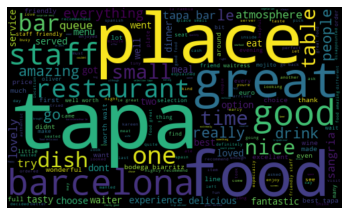

In [389]:
plt.imshow(wordCloud,interpolation="bilinear")
plt.axis("off")
plt.show()


### 2. Sentiment Analysis conclusions
#### Nos sorprende ver que dentro de un restaurante con la mejor posición en TripAdvisor tiene una cantidad grande de palabras calificadas como negativas. Sería interesante hacer una investigación de cuales son y así ver puntos debiles del restaurante a mejroar. 

In [391]:
sentiment_analysis=data_clean[[ 'Rating','Total Words Review', 'Total StopWords','Sentiment']]

In [393]:
sentiment_analysis_table=pd.pivot_table(data_clean,index=["Rating","Sentiment"], values=['Total Words Review','Total StopWords'])

In [394]:
sentiment_analysis_table

Total StopWords  Total Words Review
Rating Sentiment                                     
4      Negative         39.750000           80.166667
       Neutral          18.600000           41.600000
       Positive         33.193007           71.413986
5      Negative         37.461538           78.076923
       Positive         43.024390           89.825784

### 3. Restaurant's Client Feeling Evolution
#### We see that from 2013 till today the restaurant had the ability to stay stable and recevied an average of good review. The only time they struggled was in Jan and Feb of 2019.

In [338]:
#Here we have a table with the evolution
reviews_time_evolution=pd.pivot_table(data_clean,index=["Year of review","Month of review"], values="Polarity Rate")

In [339]:
reviews_time_evolution

Polarity Rate
Year of review Month of review               
2013           4                     0.081250
               5                     0.170588
               6                     0.208294
               7                     0.305309
               8                     0.198212
...                                       ...
2019           12                    0.362898
2020           1                     0.412677
               2                     0.377740
               3                     0.367401
               6                     0.285417

[83 rows x 1 columns]

In [340]:
#Here we have a Year-month graph with the evolution
#I found this funny way of playing with the data to be shown*

In [341]:
#Table positions: cols=Year and month, row= polarity rate, values= polarity rate, aggfunc=average.
#you might need to place those positions mentions above in the table to have the results shown. 
from pivottablejs import pivot_ui
pivot_ui(reviews_time_evolution)